In [1]:
#from user_functions import *
import xarray as xr
import pandas as pd
import cartopy.geodesic as cgeo

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import glob
import pdb

In [22]:
#function to read the raw tracker output (.txt files) and extract data into pd DataFrame rows. 
def get_track_info_orig(period,sim,stamp,hour,sql=50):
    #Reads from IMAGES_DIR (l108) in wrapper.py. File format set by tracker algorithm.
    with open("/gws/nopw/j04/lmcs/MCSMIP/simple-track_outputs/DYAMOND_{}/{}/history_S{}_T241_A10_{}.txt".format(period,sim.upper(),sql,stamp),"r") as data_file:
        storm_ids,areas,cx_vals,cy_vals,dx_vals,dy_vals=[],[],[],[],[],[]
        for line in data_file:
            data = line.split()
            if len(data) > 5:
                storm_ids.append(int(data[1]))
                areas.append(int([d for d in data if d.startswith('area=')][0].replace('area=','')))
                cx_vals.append(float([d for d in data if d.startswith('centroid=')][0].replace('centroid=','').split(',')[0]))
                cy_vals.append(float([d for d in data if d.startswith('centroid=')][0].replace('centroid=','').split(',')[1]))
                #Multiplication factor converts rawstorm speeds from pixels/timestep -> km/h:
                dx_vals.append(11*float([d for d in data if d.startswith('dx=')][0].replace('dx=','')))
                dy_vals.append(11*float([d for d in data if d.startswith('dy=')][0].replace('dy=','')))
    
    storm_data=pd.DataFrame(np.column_stack([areas,cx_vals,cy_vals,dx_vals,dy_vals]),index=storm_ids,columns=[
                            "area_{:02d}".format(hour),"clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour),"PSu_{:02d}".format(hour),"PSv_{:02d}".format(hour)])
    storm_data.index=storm_data.index.rename("storm")

    pdb.set_trace()
    storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]]=np.round(storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]])

    pdb.set_trace()
    
    return storm_data.sort_index()

In [25]:
#function to read the raw tracker output (.txt files) and extract data into pd DataFrame rows. 
def get_track_info(period,sim,stamp,hour,sql=50):
    #Reads from IMAGES_DIR (l108) in wrapper.py. File format set by tracker algorithm.
    with open("/gws/nopw/j04/lmcs/MCSMIP/simple-track_outputs/DYAMOND_{}/{}/history_S{}_T241_A10_{}.txt".format(period,sim.upper(),sql,stamp),"r") as data_file:
        storm_ids,areas,cx_vals,cy_vals,dx_vals,dy_vals,meanv,extreme,date=[],[],[],[],[],[],[],[],[]
        
        for line in data_file:
            data = line.split()
            if len(data) > 5:
                storm_ids.append(int(data[1]))
                areas.append(int([d for d in data if d.startswith('area=')][0].replace('area=','')))
                cx_vals.append(float([d for d in data if d.startswith('centroid=')][0].replace('centroid=','').split(',')[0])) # centre point
                cy_vals.append(float([d for d in data if d.startswith('centroid=')][0].replace('centroid=','').split(',')[1]))
                #Multiplication factor converts rawstorm speeds from pixels/timestep -> km/h:
                dx_vals.append(11*float([d for d in data if d.startswith('dx=')][0].replace('dx=','')))  # the velocity of this storm at this timestep as determined from pattern correlation
                dy_vals.append(11*float([d for d in data if d.startswith('dy=')][0].replace('dy=','')))
                meanv.append(float([d for d in data if d.startswith('meanv=')][0].replace('meanv=','')))
                extreme.append(float([d for d in data if d.startswith('extreme=')][0].replace('extreme=','')))
                date.append(stamp)
    storm_data=pd.DataFrame(np.column_stack([areas,cx_vals,cy_vals,dx_vals,dy_vals, meanv, extreme,date]),index=storm_ids,columns=[
                            "area_{:02d}".format(hour),"clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour),"PSu_{:02d}".format(hour),"PSv_{:02d}".format(hour), 
        "vmean_{:02d}".format(hour), "extreme_{:02d}".format(hour), "date_{:02d}".format(hour)])
    storm_data.index=storm_data.index.rename("storm")

    pdb.set_trace()
    storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]]=np.round(storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]])

    pdb.set_trace()

    return storm_data.sort_index()

In [10]:
#storm tracks give indices of position on common DYAMOND analysis grid; get grid lon/lat vals for reference
ds_ref=xr.open_dataset("/gws/nopw/j04/lmcs/MCSMIP/DYAMOND/Summer/UM/olr_pcp_instantaneous/pr_rlut_um_summer_2016090923.nc")
ref_lons=ds_ref.lon.values
ref_lats=ds_ref.lat.values

In [26]:
#Function to build complete table of tracker outputs from the raw output
#Two output tables:
# - storm_data: all data extracted from the tacker output files. Rows pertain to unique storm ids. Columns are labelled by hour since beginning of period.
#               For each hour detail storm area, centroid coordinates and velocity components. Note no post-processing done to identify MCSs here.
#               Note that most table entries are NaN, with storm values roughly clustered around the matrix diagonal.
# - storm_props: simple table that uses area threshold to isolate MCSs. Just lists MCS lifetime (hours), mean storm speed and mean storm direction; unique storm per row.
def process_storm_data(region,sim,sql=50):
    storm_data=[]
    period=pd.date_range(start="2016-08-01",end="2016-08-02",freq="H")
    print("Getting track output files")
    for i in range(len(period)):
        tstamp=period[i]
        nt=int((tstamp-period[0]).seconds/3600)
        stamp_str="%04d%02d%02d%02d"%(tstamp.year,tstamp.month,tstamp.day,tstamp.hour)
        storm_data.append(get_track_info(region,sim,stamp_str,i,sql=sql))
    storm_data=pd.concat(storm_data,axis=1)

    print("Done; calculating MCS speeds")
    prop_data = {"mcs":[],"ltime":[],"speeds":[],"dirs":[]}
    geo=cgeo.Geodesic()
    for i in range(len(storm_data)):
        storm_locs=storm_data.iloc[i].dropna()
        #MCS area threshold; 11km ~ 0.1 degree resolution of k-scale gws analysis grid. Change if different!
        #
        is_mcs = storm_locs.filter(regex="area").where(storm_locs.filter(regex="area").astype(int) > 5000/11**2).dropna()
        #NInclude cutoff to remove storms that only pop over MCS threshold once, can pollute tracking stats
        if len(is_mcs) > 1:
            prop_data["mcs"].append(storm_locs.name)
            prop_data["ltime"].append(len(is_mcs))

            #Get mean storm speeds; geodesic distance between start and end centroids / lifetime.
            storm_locs=storm_locs.filter(regex="idx")
            
            start_lon, start_lat = ref_lons[int(storm_locs.iloc[0])], ref_lats[int(storm_locs.iloc[1])]
            end_lon, end_lat = ref_lons[int(storm_locs.iloc[-2])], ref_lats[int(storm_locs.iloc[-1])]
            
            path=cgeo.Geodesic.inverse(geo,np.array((start_lon,start_lat)),np.array((end_lon,end_lat)))
        
            prop_data["speeds"].append(path[0,0] / (3600*len(storm_locs)/2))
            prop_data["dirs"].append(path[0,1])

    storm_prop=pd.DataFrame(prop_data)
    storm_prop.index = storm_prop["mcs"]
    storm_prop["dirs"][storm_prop["dirs"]<0] = storm_prop["dirs"][storm_prop["dirs"]<0] + 360

    return storm_data, storm_prop

In [ ]:
storms1, mcs_prop1 = process_storm_data("Summer","um",sql=50)
storms2, mcs_prop2 = process_storm_data("Summer","um",sql=100)

Getting track output files
> /tmp/ipykernel_533/3669579310.py(26)get_track_info()
     24 
     25     pdb.set_trace()
---> 26     storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]]=np.round(storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]])
     27 
     28     pdb.set_trace()



ipdb>  type(cx_vals)


<class 'list'>


ipdb>  type(cx_vals[0])


<class 'float'>


ipdb>  cx_vals


[1796.09, 3461.31, 492.27, 313.6, 3458.55, 3452.62, 3168.45, 363.63, 707.24, 1114.5, 3457.5, 3176.79, 372.6, 718.94, 441.02, 346.71, 312.92, 3184.95, 328.31, 1857.69, 1348.47, 50.81, 2304.65, 470.79, 2621.06, 935.43, 1176.58, 73.38, 937.52, 1167.38, 1845.93, 3417.22, 2587.88, 742.17, 1156.65, 506.56, 63.0, 2068.84, 2330.0, 65.2, 3414.95, 1775.88, 2100.69, 3448.1, 3429.6, 3107.55, 2317.45, 490.29, 2450.1, 3566.09, 111.35, 1700.24, 73.0, 1710.35, 3460.88, 420.56, 591.92, 134.67, 2488.34, 435.0, 629.95, 2413.23, 1693.84, 153.6, 1721.1, 2759.89, 692.62, 2430.53, 2468.0, 2477.21, 647.75, 3587.61, 992.85, 637.67, 27.05, 712.08, 2091.91, 657.3, 713.48, 953.0, 3572.21, 662.44, 3138.63, 0.4, 682.5, 195.88, 1645.33, 1657.89, 3125.54, 1157.22, 145.55, 926.49, 50.84, 1672.95, 1626.66, 941.9, 1644.0, 953.17, 625.48, 1654.15, 925.16, 976.42, 300.18, 574.48, 3119.65, 976.5, 643.16, 941.33, 3108.95, 550.09, 498.55, 537.29, 2333.58, 647.03, 3226.54, 1162.55, 546.25, 576.2, 2127.45, 638.41, 2285.45, 112

ipdb>  storm_data["clon_idx_01"]


*** KeyError: 'clon_idx_01'


ipdb>  storm_data["clon_idx"]


*** KeyError: 'clon_idx'


ipdb>  storm_data["clon_idx_{:02d}"]


*** KeyError: 'clon_idx_{:02d}'


ipdb>  storm_data.keys()


Index(['area_00', 'clon_idx_00', 'clat_idx_00', 'PSu_00', 'PSv_00', 'vmean_00',
       'extreme_00', 'date_00'],
      dtype='object')


ipdb>  storm_data['clon_idx_00']


storm
1      1796.09
2      3461.31
3       492.27
4        313.6
5      3458.55
        ...   
714     616.04
715      636.5
716     550.37
717     3355.1
718     394.76
Name: clon_idx_00, Length: 718, dtype: object


ipdb>  storm_data['clon_idx_00'][0]


*** KeyError: 0


ipdb>  storm_data['clon_idx_00'].iloc[0]


'1796.09'


ipdb>  type(storm_data['clon_idx_00'].iloc[0])


<class 'str'>


In [17]:
for props in [storms1, storms2]:
    print(len(props))

13984
7645


In [18]:
storms1, mcs_prop1 = process_storm_data("Summer","um",sql=50)

Getting track output files
> /tmp/ipykernel_533/2070342979.py(28)get_track_info()
     24     storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]]=np.round(storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]])
     25 
     26     pdb.set_trace()
     27 
---> 28     return storm_data.sort_index()



ipdb>  storm_data.iloc[0]


area_00            716480
clon_idx_00       1796.09
clat_idx_00        118.78
PSu_00                0.0
PSv_00                0.0
vmean_00            207.6
extreme_00         104.53
date_00        2016080100
Name: 1, dtype: object


ipdb>  np.round(storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]])


      clon_idx_00 clat_idx_00
storm                        
1         1796.09      118.78
2         3461.31       60.92
3          492.27      114.86
4           313.6       86.75
5         3458.55       91.45
...           ...         ...
714        616.04     1196.93
715         636.5     1195.82
716        550.37     1197.41
717        3355.1      1198.0
718        394.76      1198.2

[718 rows x 2 columns]


ipdb>  quit


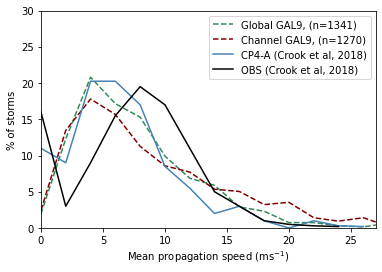

In [11]:
bins=[]
for props in [mcs_prop1,mcs_prop2]:
    mx=np.ceil(props["speeds"].max())
    bins.append(stats.binned_statistic(props["speeds"],props["speeds"],statistic='count',bins=(mx+mx%2)/2 + 1,range=(-1,mx+mx%2 + 1)))

plt.plot(bins[0].bin_edges[:-1]+1,100*bins[0].statistic/np.sum(bins[0].statistic),label="Global GAL9, (n={:.0f})".format(np.sum(bins[0].statistic)),color="seagreen",ls="--")#"darkseagreen")
plt.plot(bins[1].bin_edges[:-1]+1,100*bins[1].statistic/np.sum(bins[1].statistic),label="Channel GAL9, (n={:.0f})".format(np.sum(bins[1].statistic)),color="maroon",ls="--")#"mediumturquoise")
#plt.plot(bins[2].bin_edges[:-1]+1,100*bins[2].statistic/np.sum(bins[2].statistic),label="Channel RAL3, (n={:.0f})".format(np.sum(bins[2].statistic)),color="maroon")
#Values read manually off fig 6a of Crook et al, 2018
cp4=[11,9,20.25,20.25,17,8.5,5.5,2,3,1,0,1,0.3,0.2]
plt.plot(np.arange(0,2*len(cp4),2),cp4,label="CP4-A (Crook et al, 2018)",color="steelblue")
#plt.plot(bins[3].bin_edges[:-1]+1,100*bins[3].statistic/np.sum(bins[3].statistic),label="LAM RAL3, (n={:.0f})".format(np.sum(bins[3].statistic)),color="goldenrod")
#Values read manually off fig 6a of Crook et al, 2018
obs=[16,3,9,15.5,19.5,17,11,5,3,1,0.5,0.3,0.2]
plt.plot(np.arange(0,2*len(obs),2),obs,label="OBS (Crook et al, 2018)",color="k")
plt.legend()
plt.xlabel("Mean propagation speed (ms$^{-1}$)")
plt.ylabel("% of storms")
#plt.xticks(bins[0].bin_edges[::5],np.arange(0,30,5))
plt.xlim([0,27])#improves shear response of intense rainfall from MCSs
plt.ylim([0,30])
plt.savefig("MCS_propogation_speed_model_distributions.png",dpi=200)

(0.0, 25.0)

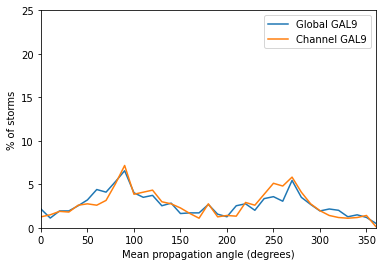

In [12]:
bins=[]
for props in [mcs_prop1, mcs_prop2]:
    bins.append(stats.binned_statistic(props["dirs"],props["dirs"],statistic='count',bins=37,range=(-5,365)))

plt.plot(bins[0].bin_edges[:-1]+5,100*bins[0].statistic/np.sum(bins[0].statistic),label="Global GAL9")
plt.plot(bins[1].bin_edges[:-1]+5,100*bins[1].statistic/np.sum(bins[1].statistic),label="Channel GAL9")
#plt.plot(bins[2].bin_edges[:-1]+5,100*bins[2].statistic/np.sum(bins[2].statistic),label="Channel RAL3")
#plt.plot(bins[3].bin_edges[:-1]+1,100*bins[3].statistic/np.sum(bins[3].statistic),label="LAM RAL3")
plt.legend()
plt.xlabel("Mean propagation angle (degrees)")
plt.ylabel("% of storms")
#plt.xticks(bins[0].bin_edges[:-1:5],[int(i) for i in (bins[0].bin_edges[:-1:5]+5)])
plt.xlim([0,360])
plt.ylim([0,25])

In [14]:
storms1.head()

,area_00,clon_idx_00,clat_idx_00,PSu_00,PSv_00,area_01,clon_idx_01,clat_idx_01,PSu_01,PSv_01,...,area_23,clon_idx_23,clat_idx_23,PSu_23,PSv_23,area_24,clon_idx_24,clat_idx_24,PSu_24,PSv_24
storm,,,,,,,,,,,,,,,,,,,,,
1,716480.0,1796.0,119.0,0.0,0.0,746977.0,1797.0,120.0,2.53,1.98,...,776497.0,1817.0,123.0,1.87,1.32,775605.0,1817.0,123.0,-0.11,0.0
2,26.0,3461.0,61.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1390.0,492.0,115.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48.0,314.0,87.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11.0,3459.0,91.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
mcs_prop1.head()

,mcs,ltime,speeds,dirs
mcs,,,,
1,1,25,1.814805,74.979816
15,15,3,15.993406,121.180509
24,24,7,13.582796,129.180451
44,44,2,11.058355,106.487166
45,45,3,10.330083,96.129327
